# Model Training

### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [150]:
#Importing recquired packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

##### Importing Modelling Libraries

In [151]:
#Importing ML packages
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

#### Importing CSV data as Pandas dataframe

In [152]:
#Loading Dataset
df = pd.read_csv('data/DWSIM.csv')

In [153]:
#Shows top 5 records
df.head()

,Reflux Ratio (R),Boilup Ratio (B),Feed Mole Fraction (xF),Feed Flowrate (F) kmol/hr,Number of Stages (N),Feed Thermal Condition (q),Distillate Mole Fraction (xD),Reboiler Duty (QR) (kW)
0,3.89,1.66,0.21,74.18,25,1,0.806,2742
1,4.54,1.36,0.67,80.39,25,1,0.853,2637
2,3.56,2.58,0.61,86.30,25,1,0.848,3062
3,4.43,1.69,0.81,71.26,25,0,0.884,2722
4,2.69,2.17,0.45,99.56,20,1,0.820,3231


In [154]:
#Shape of the dataset
df.shape

(373, 8)

#### Missing Values

In [155]:
#Checks for missing values
df.isna().sum()

Reflux Ratio (R)                 0
Boilup Ratio (B)                 0
Feed Mole Fraction (xF)          0
Feed Flowrate (F) kmol/hr        0
Number of Stages (N)             0
Feed Thermal Condition (q)       0
Distillate Mole Fraction (xD)    0
Reboiler Duty (QR) (kW)          0
dtype: int64

#### Duplicate Value

In [156]:
#Checks for duplicates
df.duplicated().sum()

np.int64(66)

In [157]:
#Deletes duplicates
df = df.drop_duplicates()

In [158]:
df.shape

(307, 8)

#### Rename Columns

In [159]:
#Renaming columns for better accessibility
df.rename(columns={
    'Reflux Ratio (R)': 'RefluxRatio',
    'Boilup Ratio (B)': 'BoilupRatio',
    'Feed Mole Fraction (xF)': 'Feed_MoleFraction',
    'Feed Flowrate (F) kmol/hr': 'Feed_Flowrate',
    'Number of Stages (N)': 'Stages',
    'Feed Thermal Condition (q)': 'Feed_ThermalCondition',
    'Distillate Mole Fraction (xD)': 'Distillate_MoleFraction',
    'Reboiler Duty (QR) (kW)': 'ReboilerDuty'
}, inplace=True)
df.head()

,RefluxRatio,BoilupRatio,Feed_MoleFraction,Feed_Flowrate,Stages,Feed_ThermalCondition,Distillate_MoleFraction,ReboilerDuty
0,3.89,1.66,0.21,74.18,25,1,0.806,2742
1,4.54,1.36,0.67,80.39,25,1,0.853,2637
2,3.56,2.58,0.61,86.30,25,1,0.848,3062
3,4.43,1.69,0.81,71.26,25,0,0.884,2722
4,2.69,2.17,0.45,99.56,20,1,0.820,3231


#### Unit Consistency Check

In [160]:
if "Feed_Flowrate" in df.columns:
    print("Feed Flowrate (kmol/h):", df["Feed_Flowrate"].min(), "to", df["Feed_Flowrate"].max())

if "ReboilerDuty" in df.columns:
    print("Reboiler Duty (kW):", df["ReboilerDuty"].min(), "to", df["ReboilerDuty"].max())

Feed Flowrate (kmol/h): 71.26 to 134.65
Reboiler Duty (kW): 2549 to 3350


In [161]:
cols = ["Distillate_MoleFraction", "ReboilerDuty", "RefluxRatio","BoilupRatio", "Feed_MoleFraction", "Feed_Flowrate","Stages", "Feed_ThermalCondition"]
print("Before unit consistency check:", df.shape)
# Distillate mole fraction must be between 0 and 1
if "Distillate_MoleFraction" in df.columns:
    df = df[(df["Distillate_MoleFraction"] >= 0) & (df["Distillate_MoleFraction"] <= 1)]

# Reboiler duty (QR): must be non-negative or within typical range
if "ReboilerDuty" in df.columns:
    df = df[df["ReboilerDuty"] >= 0]

# Boilup ratio (B): typical operating range >0 to <=10
if "BoilupRatio" in df.columns:
    df = df[(df["BoilupRatio"] > 0) & (df["BoilupRatio"] <= 10)]

# Reflux ratio (R): 0.8–5.0
if "RefluxRatio" in df.columns:
    df = df[(df["RefluxRatio"] >= 0.8) & (df["RefluxRatio"] <= 5.0)]

# Feed mole fraction of light key (xF): 0.2–0.95
if "Feed_MoleFraction" in df.columns:
    df = df[(df["Feed_MoleFraction"] >= 0.2) & (df["Feed_MoleFraction"] <= 0.95)]

# Feed flowrate (F): vary ±30% around base case (mean)
if "Feed_Flowrate" in df.columns:
    F0 = df["Feed_Flowrate"].mean()
    df = df[(df["Feed_Flowrate"] >= 0.7 * F0) & (df["Feed_Flowrate"] <= 1.3 * F0)]

# Number of stages (N): discrete values (15, 20, 25)
if "Stages" in df.columns:
    df = df[df["Stages"].isin([15, 20, 25])]

# Feed thermal condition (q): should be in [0, 1] (or other valid discrete set if known)
if "Feed_ThermalCondition" in df.columns:
    df = df[(df["Feed_ThermalCondition"] >= 0) & (df["Feed_ThermalCondition"] <= 1)]

# Remove any remaining rows with missing values after filtering
df = df.dropna(subset=cols)

print("After unit consistency check:", df.shape)


Before unit consistency check: (307, 8)
After unit consistency check: (306, 8)


In [162]:
#Independent Features
X = df.drop(columns=['Distillate_MoleFraction','ReboilerDuty'])
X.head()

,RefluxRatio,BoilupRatio,Feed_MoleFraction,Feed_Flowrate,Stages,Feed_ThermalCondition
0,3.89,1.66,0.21,74.18,25,1
1,4.54,1.36,0.67,80.39,25,1
2,3.56,2.58,0.61,86.30,25,1
4,2.69,2.17,0.45,99.56,20,1
5,1.35,2.43,0.23,87.97,15,0


In [163]:
#Dependent Features
y = df[['Distillate_MoleFraction', 'ReboilerDuty']]

In [164]:
#Train-Test Split
block_mask = X['RefluxRatio'].between(3.5, 4.5)

#Define Test set using block region
X_test = X[block_mask].reset_index(drop=True)
y_test = y[block_mask].reset_index(drop=True)

#Remaining will be used for training & validation
X_rem = X[~block_mask].reset_index(drop=True)
y_rem = y[~block_mask].reset_index(drop=True)

#Split remaining into train and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test (block) shape:", X_test.shape)

Train shape: (174, 6)
Val shape: (44, 6)
Test (block) shape: (88, 6)


In [165]:
# Define categorical and numerical feature columns
cat_features = ['Feed_ThermalCondition']
num_features = [col for col in X.columns if col not in cat_features]

# Define transformations for each feature
numeric_transformer = StandardScaler()                     # Standardize numerical features
cat_transformer = OneHotEncoder()                          # OneHot encode categorical features

#Apply scaling to numeric features and encoding to categorical features
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", cat_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

#Apply transformations to the features
X_processed = preprocessor.fit_transform(X)

In [166]:
# Check shape before and after transformation
#5 numerical & 1 categorical
X.shape      


(306, 6)

In [167]:
#5 standardized numerical features
#1 categorical feature turned into 2 one-hot encoded columns
X_processed.shape

(306, 7)

In [168]:
models = {
    "Polynomial Regression": Pipeline([
        ('pre', preprocessor),
        ('poly', PolynomialFeatures(degree=3)),
        ('linreg', MultiOutputRegressor(LinearRegression()))
    ]),
    "Random Forest": Pipeline([
        ('pre', preprocessor),
        ('rf', MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42)))
    ]),
    "AdaBoost": Pipeline([
        ('pre', preprocessor),
        ('ada', MultiOutputRegressor(AdaBoostRegressor(random_state=42)))
    ]),
    "SVR": Pipeline([
        ('pre', preprocessor),
        ('svr', MultiOutputRegressor(SVR()))
    ]),
    "XGBoost": Pipeline([
        ('pre', preprocessor),
        ('xgb', MultiOutputRegressor(XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, verbosity=0)))
    ])
}


In [169]:
#Define Hyperparameter Grids for RandomizedSearchCV
param_grids = {
    "Polynomial Regression": {
        'poly__degree': [2, 3, 4]  
    },
    "Random Forest": {
        'rf__estimator__n_estimators': [100, 200, 300],
        'rf__estimator__max_depth': [None, 5, 10, 20],
        'rf__estimator__min_samples_split': [2, 5, 10],
        'rf__estimator__min_samples_leaf': [1, 2, 4]
    },
    "AdaBoost": {
        'ada__estimator__n_estimators': [50, 100, 200],
        'ada__estimator__learning_rate': [0.01, 0.1, 1.0]
    },
    "SVR": {
        'svr__estimator__C': [0.1, 1, 10, 100],
        'svr__estimator__gamma': ['scale', 'auto'],
        'svr__estimator__kernel': ['rbf', 'poly', 'linear']
    },
    "XGBoost": {
        'xgb__estimator__n_estimators': [100, 200, 500],
        'xgb__estimator__max_depth': [3, 5, 7],
        'xgb__estimator__learning_rate': [0.01, 0.05, 0.1],
        'xgb__estimator__subsample': [0.7, 0.9, 1.0]
    }
}


In [170]:
#Performs hyperparameter tuning & evaluate model on validation and test sets
def tune_and_evaluate(models, param_grids, X_train, y_train, X_val, y_val, X_test, y_test, n_iter=10, cv=3):
    results = {}

    for name, model in models.items():
        #Check if hyperparameter grid exists for this model
        if name in param_grids:
            search = RandomizedSearchCV(
                model,
                param_distributions=param_grids[name],
                n_iter=n_iter,
                scoring='r2',
                cv=cv,
                random_state=42,
                n_jobs=-1,
                verbose=1
            )
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
            
        else:
            #If no hyperparameter grid is defined for this model, fit the base model.
            best_model = model.fit(X_train, y_train)

        #Evaluate model on validation set
        y_val_pred = best_model.predict(X_val)
        mae_val = mean_absolute_error(y_val, y_val_pred)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
        r2_val = r2_score(y_val, y_val_pred)

        #Evaluate model on test set
        y_test_pred = best_model.predict(X_test)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        r2_test = r2_score(y_test, y_test_pred)

        #Storing results
        results[name] = {
            "Best Model": best_model,
            "Val MAE": mae_val,
            "Val RMSE": rmse_val,
            "Val R²": r2_val,
            "Test MAE": mae_test,
            "Test RMSE": rmse_test,
            "Test R²": r2_test
        }
    return results
results = tune_and_evaluate(models, param_grids, X_train, y_train, X_val, y_val, X_test, y_test)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [171]:
#Converting results to dataframe
metrics_table = pd.DataFrame([
    {
        "Model": name,
        "Val MAE": metrics["Val MAE"],
        "Val RMSE": metrics["Val RMSE"],
        "Val R²": metrics["Val R²"],
        "Test MAE": metrics["Test MAE"],
        "Test RMSE": metrics["Test RMSE"],
        "Test R²": metrics["Test R²"]
    }
    for name, metrics in results.items()
])

metrics_table


,Model,Val MAE,Val RMSE,Val R²,Test MAE,Test RMSE,Test R²
0,Polynomial Regression,35.436704,70.165793,0.622332,42.629556,74.513415,0.465625
1,Random Forest,18.161901,36.785611,0.909269,32.277585,63.261947,0.638175
2,AdaBoost,35.116613,61.219720,0.780320,32.922162,67.372366,0.509429
3,SVR,28.631454,57.738724,0.294044,44.335451,81.232585,-1.667865
4,XGBoost,15.845323,35.877263,0.918558,36.110100,69.071478,0.606942


#### Physical Consistency Check 

##### Enforce Physical Bounds

In [172]:
#Enforce physical bounds on model predictions
best_model = results["XGBoost"]["Best Model"]

y_test_pred = best_model.predict(X_test)

y_test_pred = pd.DataFrame(y_test_pred, columns=['Distillate_MoleFraction', 'ReboilerDuty'])
y_test_true = pd.DataFrame(y_test, columns=['Distillate_MoleFraction', 'ReboilerDuty'])

#Bounds check: enforce 0 <= xD <= 1
y_test_pred['Distillate_MoleFraction'] = y_test_pred['Distillate_MoleFraction'].clip(0, 1)

##### Monotonic Sanity Check

In [173]:
#Monotonic sanity check
def monotonic_check(X, y_pred):
    violations = 0
    grouped = pd.concat([X.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
    for (xF, N), g in grouped.groupby(['Feed_MoleFraction', 'Stages']):
        g_sorted = g.sort_values('RefluxRatio')
        if (g_sorted['Distillate_MoleFraction'].diff().dropna() < -1e-3).any():
            violations += 1
    print(f"Monotonicity violations found: {violations}")

monotonic_check(X_test, y_test_pred)

Monotonicity violations found: 5


##### Sensitivity Plot

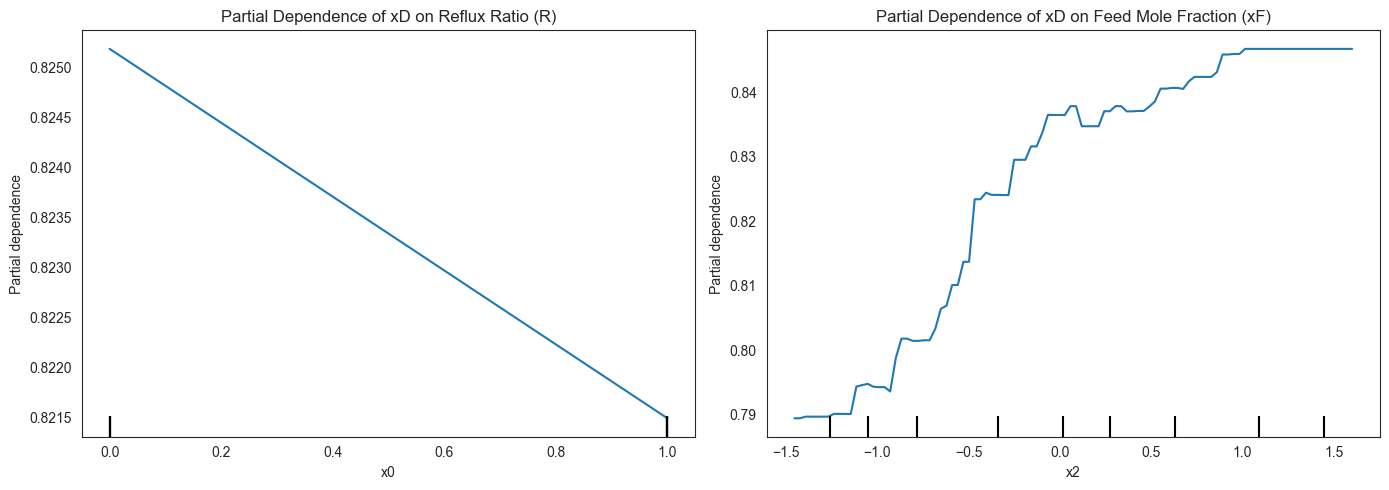

In [174]:
from sklearn.inspection import PartialDependenceDisplay

#Get the first estimator from MultiOutputRegressor
xd_model = results["XGBoost"]["Best Model"].named_steps["xgb"].estimators_[0]
X_processed = preprocessor.transform(X)

reflux_idx = num_features.index("RefluxRatio")
feed_idx = num_features.index("Feed_MoleFraction")

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Partial dependence of xD vs Reflux Ratio
PartialDependenceDisplay.from_estimator(xd_model, X_processed, features=[reflux_idx], ax=ax[0], kind='average')
ax[0].set_title('Partial Dependence of xD on Reflux Ratio (R)')

#Partial dependence of xD vs Feed Mole Fraction
PartialDependenceDisplay.from_estimator(xd_model, X_processed, features=[feed_idx], ax=ax[1], kind='average')
ax[1].set_title('Partial Dependence of xD on Feed Mole Fraction (xF)')

plt.tight_layout()
plt.show()

##### Error Slice Analysis

In [175]:
#Error slices: high purity region (xD ≥ 0.95)
mask_hp = y_test_true['Distillate_MoleFraction'] >= 0.95
if mask_hp.any():
    mae_hp = mean_absolute_error(y_test_true.loc[mask_hp, 'Distillate_MoleFraction'], y_test_pred.loc[mask_hp, 'Distillate_MoleFraction'])
    rmse_hp = np.sqrt(mean_squared_error(y_test_true.loc[mask_hp, 'Distillate_MoleFraction'], y_test_pred.loc[mask_hp, 'Distillate_MoleFraction']))
    r2_hp = r2_score(y_test_true.loc[mask_hp, 'Distillate_MoleFraction'], y_test_pred.loc[mask_hp, 'Distillate_MoleFraction'])
    print("High-purity region metrics (Distillate_MoleFraction ≥ 0.95):")
    print(f"  MAE  = {mae_hp:.4f}")
    print(f"  RMSE = {rmse_hp:.4f}")
    print(f"  R²   = {r2_hp:.4f}")
else:
    print("No samples in test set with Distillate_MoleFraction ≥ 0.95")

No samples in test set with Distillate_MoleFraction ≥ 0.95


#### Evaluation

##### Performance Metrics

In [176]:
metrics_table

,Model,Val MAE,Val RMSE,Val R²,Test MAE,Test RMSE,Test R²
0,Polynomial Regression,35.436704,70.165793,0.622332,42.629556,74.513415,0.465625
1,Random Forest,18.161901,36.785611,0.909269,32.277585,63.261947,0.638175
2,AdaBoost,35.116613,61.219720,0.780320,32.922162,67.372366,0.509429
3,SVR,28.631454,57.738724,0.294044,44.335451,81.232585,-1.667865
4,XGBoost,15.845323,35.877263,0.918558,36.110100,69.071478,0.606942


##### Parity Plots

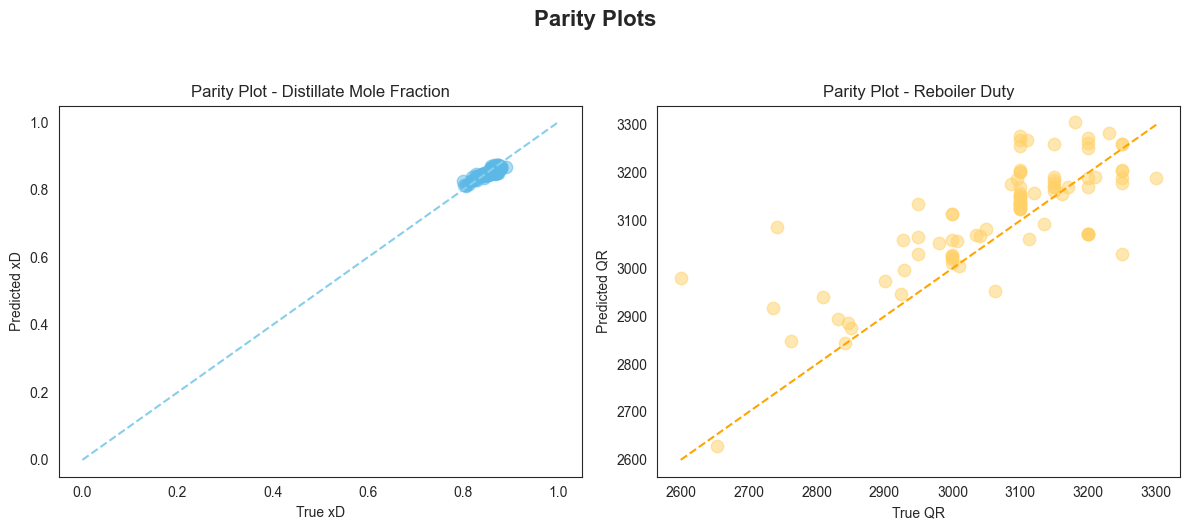

In [177]:
#Parity Plots for Model Predictions
if isinstance(y_test_pred, pd.DataFrame):
    y_test_pred = y_test_pred.values

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Parity Plots", fontsize=16, fontweight='bold', y=1.05)

#Parity Plot for Distillate Mole Fraction
axes[0].scatter(y_test['Distillate_MoleFraction'], y_test_pred[:, 0], s=80, alpha=0.5, color="#5CB8E6")
axes[0].plot([0, 1], [0, 1], '--', color='skyblue')
axes[0].set_xlabel("True xD")
axes[0].set_ylabel("Predicted xD")
axes[0].set_title("Parity Plot - Distillate Mole Fraction")

#Parity Plot for Reboiler Duty
qr_min, qr_max = y_test['ReboilerDuty'].min(), y_test['ReboilerDuty'].max()
axes[1].scatter(y_test['ReboilerDuty'], y_test_pred[:, 1], s=80, alpha=0.5, color="#FFD166")
axes[1].plot([qr_min, qr_max], [qr_min, qr_max], '--', color='orange')
axes[1].set_xlabel("True QR")
axes[1].set_ylabel("Predicted QR")
axes[1].set_title("Parity Plot - Reboiler Duty")

plt.tight_layout()
plt.show()



##### Residual Plot vs Each Input Feature

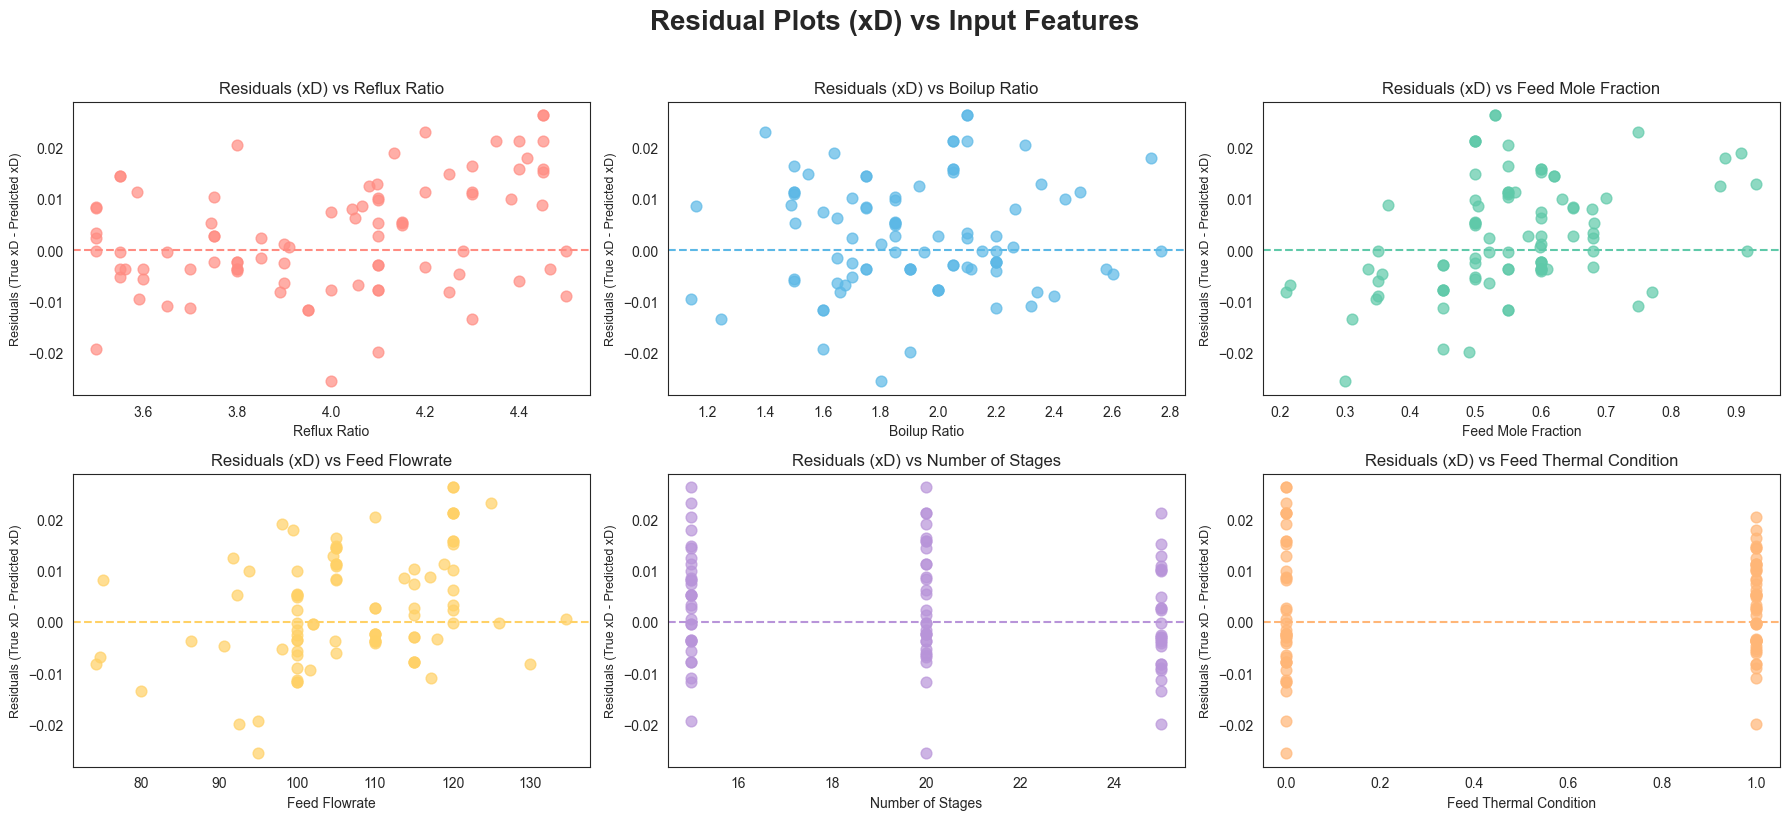

In [178]:
#Residual Plots for Distillate Mole Fraction vs Each Input Feature

#Compute residuals for Distillate Mole Fraction
residuals = y_test['Distillate_MoleFraction'] - y_test_pred[:, 0]

columns = [
    ('RefluxRatio', '#FF8C82', 'Reflux Ratio'),
    ('BoilupRatio', '#5CB8E6', 'Boilup Ratio'),
    ('Feed_MoleFraction', '#5FC9A9', 'Feed Mole Fraction'),
    ('Feed_Flowrate', '#FFD166', 'Feed Flowrate'),
    ('Stages', '#B894D9', 'Number of Stages'),
    ('Feed_ThermalCondition', '#FFB677', 'Feed Thermal Condition')
]

sns.set_style("white")
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle("Residual Plots (xD) vs Input Features", fontsize=20, fontweight="bold", y=1.02)
axes = axes.flatten()

for ax, (col, color, title) in zip(axes, columns):
    ax.scatter(X_test[col], residuals, s=60, alpha=0.7, c=color)
    ax.axhline(0, color=color, linestyle='--', linewidth=1.5)
    ax.set_xlabel(title, fontsize=10)
    ax.set_ylabel("Residuals (True xD - Predicted xD)", fontsize=9)
    ax.set_title(f"Residuals (xD) vs {title}", fontsize=12)

plt.tight_layout()
plt.show()


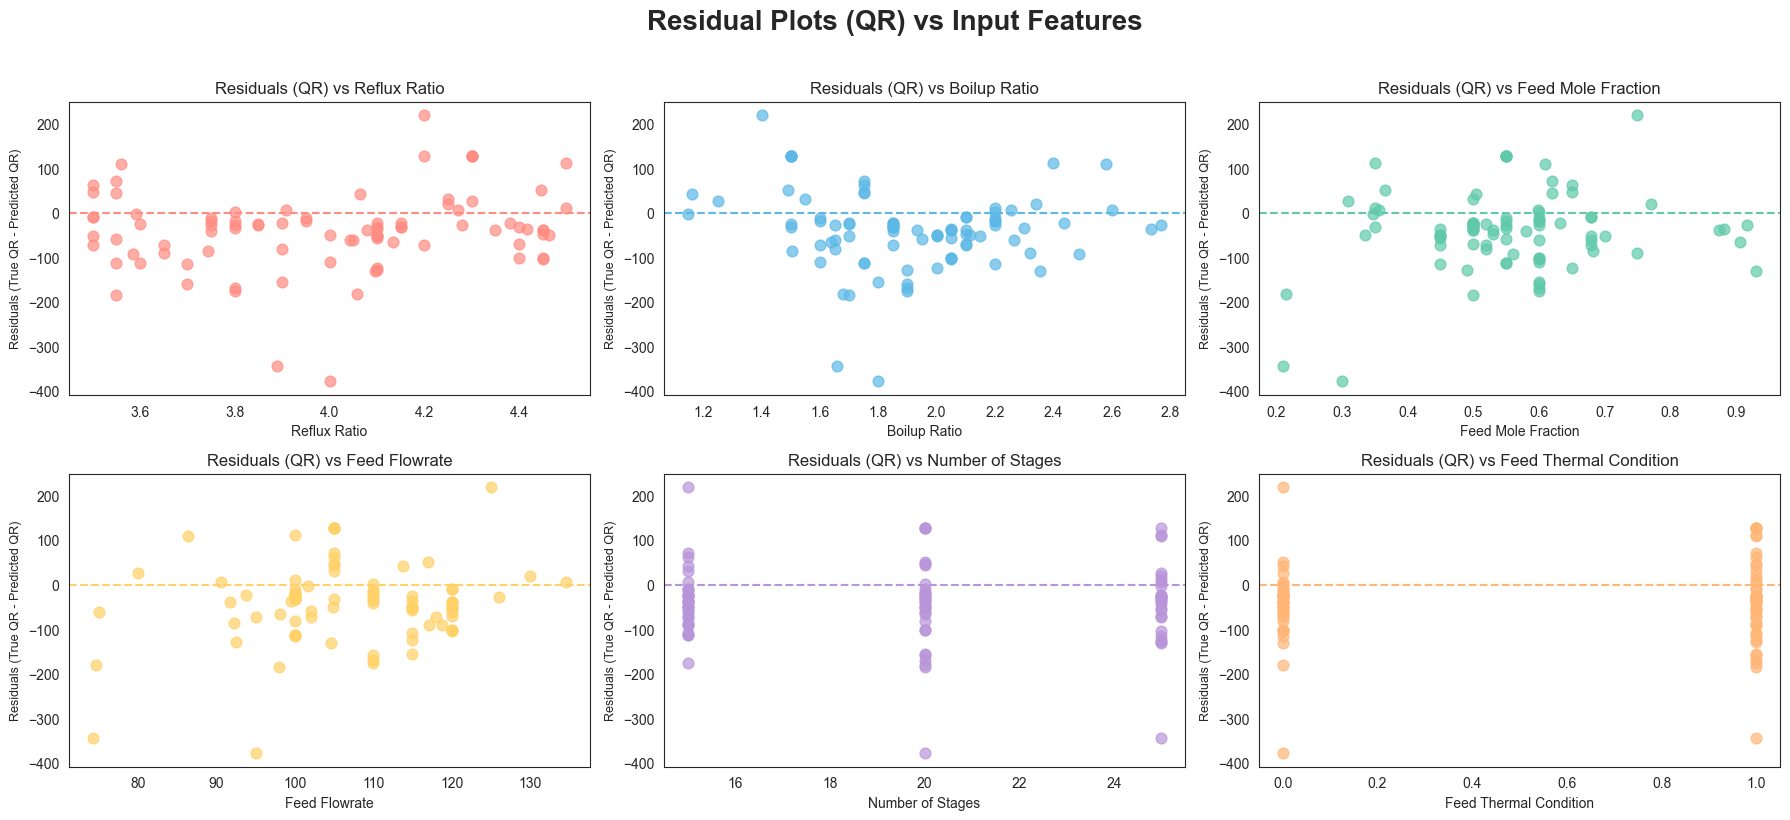

In [179]:
#Residual Plots for Reboiler Duty vs Each Input Feature

#Compute residuals for Reboiler Duty
residuals = y_test['ReboilerDuty'] - y_test_pred[:, 1]

sns.set_style("white")
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle("Residual Plots (QR) vs Input Features", fontsize=20, fontweight="bold", y=1.02)
axes = axes.flatten()

for ax, (col, color, title) in zip(axes, columns):
    ax.scatter(X_test[col], residuals, s=60, alpha=0.7, c=color)
    ax.axhline(0, color=color, linestyle='--', linewidth=1.5)
    ax.set_xlabel(title, fontsize=10)
    ax.set_ylabel("Residuals (True QR - Predicted QR)", fontsize=9)
    ax.set_title(f"Residuals (QR) vs {title}", fontsize=12)

plt.tight_layout()
plt.show()


#### Generalisation Check

In [180]:
test_region = X_test[(X_test['RefluxRatio'] >= 3.5) & (X_test['RefluxRatio'] <= 4.5)]
y_test_region = y_test.loc[test_region.index]

metrics_table['Generalization Gap'] = metrics_table['Val R²'] - metrics_table['Test R²']
metrics_table[['Model','Val R²','Test R²','Generalization Gap']]

,Model,Val R²,Test R²,Generalization Gap
0,Polynomial Regression,0.622332,0.465625,0.156707
1,Random Forest,0.909269,0.638175,0.271094
2,AdaBoost,0.780320,0.509429,0.270892
3,SVR,0.294044,-1.667865,1.961909
4,XGBoost,0.918558,0.606942,0.311616
